# Gear tooth failure prediction

Dataset taken from Kaggle.


https://www.kaggle.com/datasets/brjapon/gearbox-fault-diagnosis

## Loading Dataset
The entire dataset zip file contains two folders - Healthy and BrokenTooth. As the name suggests, BrokenTooth folder contains the failure dataset while Healthy folder contains normal dataset.

Each folder contains 10 files corresponding to applied load on the gears in percentage (0 - 90%). For our project, we have taken only the data corresponding to applied load of 50%.

In [1]:
# Import the required libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, recall_score, classification_report, precision_score

In [2]:
broken_dataset_url = "https://raw.githubusercontent.com/CS-Chinmay10/DMMS_Gearbox-fault-diagnosis-dataset/main/broken/b30hz50.csv"
healthy_dataset_url = "https://raw.githubusercontent.com/CS-Chinmay10/DMMS_Gearbox-fault-diagnosis-dataset/main/healthy/h30hz50.csv"

In [3]:
broken_df = pd.read_csv(broken_dataset_url, header=0)  # Broken tooth (failure) dataset.
healthy_df = pd.read_csv(healthy_dataset_url, header=0) # Healthy (normal) dataset.
# Add applied load at the end of df.
broken_df["applied_load"] = 50 * np.ones((broken_df.shape[0], 1))
healthy_df["applied_load"] = 50 * np.ones((healthy_df.shape[0], 1))

In [4]:
broken_df

,a1,a2,a3,a4,applied_load
0,-3.93468,6.55216,-1.237980,20.310300,50.0
1,2.40285,9.99438,-3.242650,8.313200,50.0
2,6.24273,-3.17577,-0.686974,-4.193820,50.0
3,-3.99411,-14.14480,3.845360,-5.658600,50.0
4,1.76551,-6.46492,5.096230,-9.001360,50.0
...,...,...,...,...,...
94203,-1.46153,2.78470,-1.151670,-4.537800,50.0
94204,-3.87952,0.85365,6.423880,-5.474920,50.0
94205,1.73315,4.06958,5.364500,0.216419,50.0
94206,8.97857,10.06520,1.552720,3.656620,50.0


In [5]:
healthy_df

,a1,a2,a3,a4,applied_load
0,2.144160,-1.958210,-0.190533,-4.584750,50.0
1,-9.920150,-7.475190,1.794680,-7.472510,50.0
2,-1.330590,0.751472,-3.557400,0.328149,50.0
3,7.761710,-1.498460,-1.764630,10.991900,50.0
4,-0.714011,-0.164771,9.650560,8.970950,50.0
...,...,...,...,...,...
110843,3.245040,-2.692110,2.714350,-0.639589,50.0
110844,1.347960,-2.303540,2.583290,-1.174450,50.0
110845,0.003272,-3.241480,-1.423700,-0.610475,50.0
110846,-0.031329,-3.361870,-1.493090,-2.147170,50.0


In [6]:
# Check to see if there are any null values.
print(healthy_df.isna().sum())

a1              0
a2              0
a3              0
a4              0
applied_load    0
dtype: int64


In [7]:
print(broken_df.isna().sum())

a1              0
a2              0
a3              0
a4              0
applied_load    0
dtype: int64


There are no null values present in the dataset.

## Feature engineering
In predictive maintenance, normally the data obtained is a time-series data. In order to process it, various time and frequency domain features need to be computed so that the dataset can be better analyzed and provide more info.

For doing this, we have used a third party library called TSFEL (abbreviation for Time Series Feature Extraction Library). TSFEL automatically extracts over 60 different features on the statistical, temporal and spectral domains.

In [8]:
!pip install tsfel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 46 kB 2.1 MB/s 
     |████████████████████████████████| 1.6 MB 9.0 MB/s 


In [9]:
import tsfel

In order to extract the features, tsfel requires a configuration file, which is essentially a JSON file (similar to python dictionary). This file contains all the features that are to be computed. If only some features need to be computed, the same can be achieved by editing this JSON file in a code editor.

Here, we are computing **all the possible features** that are available in TSFEL. Since we are computing all features, feature extraction takes time to complete. For us, it took **12 minutes** to complete on Google Colab.

In [10]:
cfg_file = tsfel.get_features_by_domain()

The features will be computed on the four accelerometer sensor columns with a sampling of 30 Hz and window_size of 20.

In [11]:
main_df_healthy = tsfel.time_series_features_extractor(cfg_file, healthy_df[["a1", "a2", "a3", "a4"]], fs=30, window_size=20)

*** Feature extraction started ***



*** Feature extraction finished ***


In [12]:
# Add label (0) at end of df.
main_df_healthy["failure_label"] = np.zeros((main_df_healthy.shape[0], 1))

In [13]:
main_df_healthy.shape

(5542, 581)

In [14]:
# Repeat same with failure dataset.
main_df_broken = tsfel.time_series_features_extractor(cfg_file, broken_df[["a1", "a2", "a3", "a4"]], fs=30, window_size=20)

*** Feature extraction started ***



*** Feature extraction finished ***


In [15]:
# Add label (1) to end of df.
main_df_broken["failure_label"] = np.ones((main_df_broken.shape[0], 1))

In [16]:
main_df_broken.shape

(4710, 581)

In [17]:
# Combine both time sampled dfs into single df.
final_df = pd.concat([main_df_healthy, main_df_broken], axis=0, ignore_index=True)
final_df.to_csv("final_df.csv", index=False)

## Selecting the best features
Not all the features extracted using TSFEL will have significant effect on predicting failure of gear tooth. So, only those features are selected which are helpful in predicting the failure.



In [18]:
X = final_df.drop("failure_label", axis=1)
y = final_df.failure_label

In [19]:
# Extract the best features from the entire feature set.
x1 = X
y = final_df.failure_label
df_correlated_features = tsfel.correlated_features(x1)
x1.drop(df_correlated_features, axis=1, inplace=True)
print("Shape of x1:", x1.shape)

Shape of x1: (10252, 399)


Using **Recursive Feature Elimination with Cross Validation (RFECV)** model from scikit-learn library to eliminate features.

In [20]:
rfecv = RFECV(estimator=SVC(kernel="linear"), step=1, cv=StratifiedKFold(4),
              scoring="accuracy")

In [21]:
rfetrain = rfecv.fit(x1, y)

In [22]:
print("Number of optimal features:", rfecv.n_features_)

Number of optimal features: 68


After getting the best features, the remaining features are eliminated from the dataset. 

In [23]:
# Exporting the optimal features set as a csv file for later use.
selected_features = x1.iloc[:, rfecv.support_]
selected_features.to_csv("optimal_final_df.csv", index=False)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


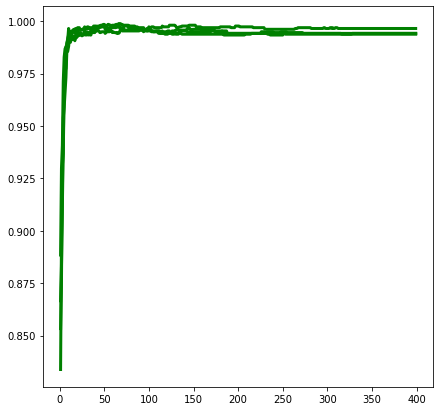

In [24]:
# Plot for RFECV
fig, axes = plt.subplots()
fig.set_figwidth(7)
fig.set_figheight(7)

axes.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_, 
          color="green", linewidth=3)
plt.show()

## Build classification model

In [25]:
# Load the dataset.
optimal_df_url = "https://raw.githubusercontent.com/CS-Chinmay10/DMMS_Gearbox-fault-diagnosis-dataset/main/optimal_final_df.csv"

In [26]:
optimal_df = pd.read_csv(optimal_df_url, header=0)  # Contains only features
optimal_df.reset_index(inplace=True, drop=True)

In [27]:
y = final_df.failure_label  # Label: 0 - Healthy, 1 - BrokenTooth

In [28]:
X_train_optimal, X_test_optimal, y_train, y_test = train_test_split(
    optimal_df, y, test_size=0.3, random_state=100
)

In [29]:
# Apply feature scaling
scaler1 = StandardScaler()

In [30]:
scaler1.fit(X_train_optimal)

StandardScaler()

In [31]:
scaled_X_train_optimal = pd.DataFrame(scaler1.transform(X_train_optimal), columns=X_train_optimal.columns)

In [32]:
scaled_X_test_optimal = pd.DataFrame(scaler1.transform(X_test_optimal), columns=X_test_optimal.columns)

In [33]:
scaled_X_train_optimal.head()

,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_Histogram_2,0_Histogram_5,0_Histogram_8,0_LPCC_6,0_Mean absolute diff,...,3_Histogram_7,3_LPCC_0,3_LPCC_1,3_Mean absolute diff,3_Median absolute diff,3_Spectral kurtosis,3_Spectral skewness,3_Wavelet energy_2,3_Wavelet energy_3,3_Zero crossing rate
0,1.937855,0.775222,-0.207503,-0.021783,-0.354873,-0.547282,-0.550943,-0.534645,-1.221192,0.878755,...,-0.623177,-1.164132,-1.655143,2.478377,3.213810,-0.915064,-2.187701,1.366079,1.971370,1.716527
1,2.463975,0.046537,-0.452737,-0.496094,-0.505065,-0.547282,-0.550943,-0.534645,-0.180890,-0.798341,...,-0.623177,-0.019909,1.943159,-0.250521,0.054151,3.071223,2.715172,1.700520,1.340225,-0.881726
2,-0.601632,-0.674382,-0.535537,-0.465822,-0.126242,2.903769,-0.550943,3.035955,0.162368,-0.776520,...,0.875455,-0.311002,1.232178,-1.503545,-1.359160,1.053828,2.088573,-0.627637,-0.297449,0.677226
3,7.173622,7.435461,-0.313966,-0.395136,-0.503304,-0.547282,-0.550943,-0.534645,-0.951640,0.055176,...,-0.623177,-0.721595,0.448687,1.094166,1.006079,0.812997,0.470869,0.986943,1.298572,-0.362075
4,-0.634001,0.570619,-0.556254,-0.515678,-0.502625,-0.547282,-0.550943,-0.534645,0.011483,-0.481187,...,-0.623177,-0.401030,-0.728905,-0.728026,-0.824544,-1.299975,-1.161763,-1.156642,-1.045322,1.196876


In [34]:
scaled_X_test_optimal.head()

,0_FFT mean coefficient_1,0_FFT mean coefficient_2,0_FFT mean coefficient_3,0_FFT mean coefficient_4,0_FFT mean coefficient_5,0_Histogram_2,0_Histogram_5,0_Histogram_8,0_LPCC_6,0_Mean absolute diff,...,3_Histogram_7,3_LPCC_0,3_LPCC_1,3_Mean absolute diff,3_Median absolute diff,3_Spectral kurtosis,3_Spectral skewness,3_Wavelet energy_2,3_Wavelet energy_3,3_Zero crossing rate
0,-0.615865,-0.564857,0.518000,-0.485667,-0.397379,-0.547282,-0.550943,-0.534645,0.707769,-0.824965,...,-0.623177,-0.374995,0.638113,-0.902547,-1.079842,-0.731382,-0.019261,-0.587512,-0.559209,0.157575
1,-0.694057,-0.541895,-0.369317,-0.496068,0.063937,-0.547282,-0.550943,-0.534645,-0.069631,-0.430262,...,-0.623177,-1.213049,0.694857,-0.855896,-0.919459,0.140002,1.093993,-0.190553,-0.332912,-0.881726
2,-0.675247,0.469088,1.679617,-0.246453,-0.430847,-0.547282,-0.550943,-0.534645,1.880417,1.786035,...,-0.623177,1.562603,-0.884865,0.989423,0.940755,-0.511964,-0.653537,0.537631,0.790927,1.196876
3,0.304504,-0.401686,-0.559494,0.414535,0.318229,-0.547282,1.156124,-0.534645,0.315604,1.086893,...,-0.623177,-0.558536,1.239462,-0.936759,-0.801150,2.679604,3.143983,2.601544,3.533628,-1.401376
4,-0.297214,-0.415561,1.150910,-0.421528,-0.405975,1.178244,-0.550943,-0.534645,1.951621,-0.451138,...,2.374086,-0.637068,-0.702485,-0.228921,-0.425670,0.139364,0.290972,-0.559803,-1.058349,-0.362075


We used different classification models so that the model which gives the best performance can be selected.

### Model 1: Support Vector Classifier using linear kernel

In [35]:
lin_clf = SVC(kernel="linear", random_state=100)
lin_clf.fit(scaled_X_train_optimal, y_train)

SVC(kernel='linear', random_state=100)

In [36]:
# Generate predictions for test set.
lin_clf_preds = lin_clf.predict(scaled_X_test_optimal)

In [37]:
# Assess the accuracy score obtained on test set.
lin_acc_score = accuracy_score(y_test, lin_clf_preds)
print(lin_acc_score)

0.997074122236671


In [38]:
# Precision score
lin_prec_score = precision_score(y_test, lin_clf_preds)
print(lin_prec_score)

0.9944367176634215


In [39]:
# Confusion matrix
print(confusion_matrix(y_test, lin_clf_preds))

[[1637    8]
 [   1 1430]]


In [40]:
# f1_score
lin_f1_score = f1_score(y_test, lin_clf_preds)
print(lin_f1_score)

0.9968630184733357


In [41]:
# Recall score
lin_recall_score = recall_score(y_test, lin_clf_preds)
print(lin_recall_score)

0.9993011879804332


In [42]:
# Classification report
print(classification_report(y_test, lin_clf_preds, digits=5))

              precision    recall  f1-score   support

         0.0    0.99939   0.99514   0.99726      1645
         1.0    0.99444   0.99930   0.99686      1431

    accuracy                        0.99707      3076
   macro avg    0.99691   0.99722   0.99706      3076
weighted avg    0.99709   0.99707   0.99707      3076



### Model 2: Support Vector Classifier using RBF kernel

In [43]:
rbf_clf = SVC(kernel="rbf", random_state=100)

In [44]:
# Training
rbf_clf.fit(scaled_X_train_optimal, y_train)

SVC(random_state=100)

In [45]:
# Generate predictions for test set.
rbf_clf_preds = rbf_clf.predict(scaled_X_test_optimal)

In [46]:
# Assess the accuracy score obtained on test set.
rbf_acc_score = accuracy_score(y_test, rbf_clf_preds)
print(rbf_acc_score)

0.9931729518855656


In [47]:
# Precision score
rbf_prec_score = precision_score(y_test, rbf_clf_preds)
print(rbf_prec_score)

0.9889042995839112


In [48]:
# Confusion matrix
print(confusion_matrix(y_test, rbf_clf_preds))

[[1629   16]
 [   5 1426]]


In [49]:
# f1_score
rbf_f1_score = f1_score(y_test, rbf_clf_preds)
print(rbf_f1_score)

0.9926905673512009


In [50]:
# Recall score
rbf_recall_score = recall_score(y_test, rbf_clf_preds)
print(rbf_recall_score)

0.9965059399021663


In [51]:
# Classification report
print(classification_report(y_test, rbf_clf_preds, digits=5))

              precision    recall  f1-score   support

         0.0    0.99694   0.99027   0.99360      1645
         1.0    0.98890   0.99651   0.99269      1431

    accuracy                        0.99317      3076
   macro avg    0.99292   0.99339   0.99314      3076
weighted avg    0.99320   0.99317   0.99317      3076



### Model 3: MLPClassifier (using Neural Network)

In [52]:
# Model 3: Neural Network Implementation
from sklearn.neural_network import MLPClassifier

In [53]:
nn_clf = MLPClassifier(max_iter=1000, random_state=100)

In [54]:
nn_clf.fit(scaled_X_train_optimal, y_train)

MLPClassifier(max_iter=1000, random_state=100)

In [55]:
# Generate predictions for test set.
nn_clf_preds = nn_clf.predict(scaled_X_test_optimal)

In [56]:
# Assess the accuracy score obtained on test set.
nn_acc_score = accuracy_score(y_test, nn_clf_preds)
print(nn_acc_score)

0.9960988296488946


In [57]:
# Precision score
nn_prec_score = precision_score(y_test, nn_clf_preds)
print(nn_prec_score)

0.9937369519832986


In [58]:
# Confusion matrix
print(confusion_matrix(y_test, nn_clf_preds))

[[1636    9]
 [   3 1428]]


In [59]:
# f1_score
nn_f1_score = f1_score(y_test, nn_clf_preds)
print(nn_f1_score)

0.9958158995815899


In [60]:
# Recall score
nn_recall_score = recall_score(y_test, nn_clf_preds)
print(nn_recall_score)

0.9979035639412998


In [61]:
# Classification report
print(classification_report(y_test, nn_clf_preds, digits=5))

              precision    recall  f1-score   support

         0.0    0.99817   0.99453   0.99635      1645
         1.0    0.99374   0.99790   0.99582      1431

    accuracy                        0.99610      3076
   macro avg    0.99595   0.99622   0.99608      3076
weighted avg    0.99611   0.99610   0.99610      3076



### Model 4: Decision Tree Classifier

In [62]:
# Model 4: Decision Tree Classification
from sklearn.tree import DecisionTreeClassifier

In [63]:
dtc_clf = DecisionTreeClassifier(criterion="entropy")

In [64]:
dtc_clf.fit(scaled_X_train_optimal, y_train)

DecisionTreeClassifier(criterion='entropy')

In [65]:
# Generate predictions for test set.
dtc_clf_preds = dtc_clf.predict(scaled_X_test_optimal)

In [66]:
# Assess the accuracy score obtained on test set.
dtc_acc_score = accuracy_score(y_test, dtc_clf_preds)
print(dtc_acc_score)

0.9791937581274383


In [67]:
# Precision score
dtc_prec_score = precision_score(y_test, dtc_clf_preds)
print(dtc_prec_score)

0.9769713886950454


In [68]:
# Confusion matrix
print(confusion_matrix(y_test, dtc_clf_preds))

[[1612   33]
 [  31 1400]]


In [69]:
# f1_score
dtc_f1_score = f1_score(y_test, dtc_clf_preds)
print(dtc_f1_score)

0.9776536312849162


In [70]:
# Recall score
dtc_recall_score = recall_score(y_test, dtc_clf_preds)
print(dtc_recall_score)

0.9783368273934312


In [71]:
# Classification report
print(classification_report(y_test, dtc_clf_preds, digits=5))

              precision    recall  f1-score   support

         0.0    0.98113   0.97994   0.98054      1645
         1.0    0.97697   0.97834   0.97765      1431

    accuracy                        0.97919      3076
   macro avg    0.97905   0.97914   0.97909      3076
weighted avg    0.97920   0.97919   0.97919      3076



### Summary of model performance

In [72]:
lin_performance_data = [lin_acc_score, lin_prec_score, lin_recall_score, lin_f1_score]
rbf_performance_data = [rbf_acc_score, rbf_prec_score, rbf_recall_score, rbf_f1_score]
nn_performance_data = [nn_acc_score, nn_prec_score, nn_recall_score, nn_f1_score]
dtc_performance_data = [dtc_acc_score, dtc_prec_score, dtc_recall_score, dtc_f1_score]


In [73]:
performance_df = pd.DataFrame([lin_performance_data, rbf_performance_data, nn_performance_data, dtc_performance_data],
                       columns=["Accuracy", "Precision", "Recall", "F1"],
                       index=["SVC Linear Kernel", "SVC RBF Kernel", "MLPClassifier", "Decision Tree Classifier"])

In [74]:
performance_df

,Accuracy,Precision,Recall,F1
SVC Linear Kernel,0.997074,0.994437,0.999301,0.996863
SVC RBF Kernel,0.993173,0.988904,0.996506,0.992691
MLPClassifier,0.996099,0.993737,0.997904,0.995816
Decision Tree Classifier,0.979194,0.976971,0.978337,0.977654


From above table, it can be seen that SVC using linear kernel gave the best scores in all the metrics. Hence, it can be used as the model for predicting failure of gear tooth.